In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
import os
os.environ['METALHOME'] = '/Users/vincentchen/code/metal'

In [5]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel
from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import plot_xy, visualize_payload

In [6]:
# choices -> 'naive', hard_param', 'soft_param'
MODEL_NAME = 'naive'

## Create Tasks and Payloads
Initializes appropriate slice labelsets/slice heads

In [7]:
# define slice fns
identity_fn = lambda x: torch.from_numpy(np.ones(x.shape[0], dtype=np.uint8))

In [8]:
uid_lists, Xs, Ys = generate_data(N=2000)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [9]:
critical_slice_fn = partial(get_circle_mask, center=(0.3, 0), radius=0.3)
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, 
   slice_funcs={"critical_slice": critical_slice_fn}
)[2] # take test set

Vizualizing labelset_gold from payload_test...


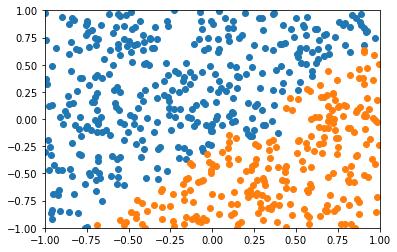

Vizualizing labelset:critical_slice from payload_test...


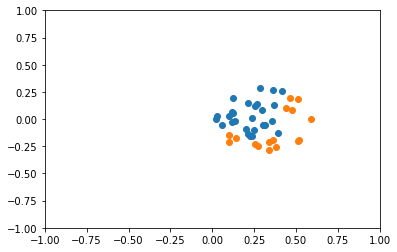

In [10]:
visualize_payload(eval_payload)

### Create tasks and payloads

In [11]:
if MODEL_NAME == 'naive':
    slice_funcs = {"BASE": identity_fn}
    model_class = MetalModel
elif MODEL_NAME == 'hard_param':
    slice_funcs = {"critical_slice": critical_slice_fn, "BASE": identity_fn}
    model_class = MetalModel
elif MODEL_NAME == 'soft_param':
    slice_funcs = {"critical_slice": critical_slice_fn, "BASE": identity_fn}
    model_class = SliceModel
else:
    raise ValueError(f"{MODEL_NAME} model not defined.")

In [12]:
tasks = create_tasks(task_name, slice_names=list(slice_funcs.keys()))
tasks

[BinaryClassificationTask(name=test_task, loss_multiplier=1.00, is_slice=False),
 BinaryClassificationTask(name=test_task:BASE, loss_multiplier=1.00, is_slice=True)]

In [13]:
payloads = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, slice_funcs=slice_funcs)
payloads

[Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:BASE': 'test_task:BASE'}], split=train),
 Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:BASE': 'test_task:BASE'}], split=valid),
 Payload(payload_test: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:BASE': 'test_task:BASE'}], split=test)]

#### Visualize Train Payloads

Vizualizing labelset_gold from payload_train...


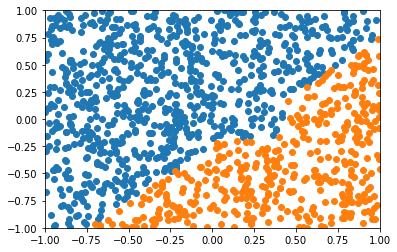

Vizualizing labelset:BASE from payload_train...


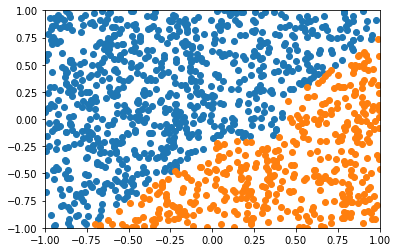

In [14]:
visualize_payload(payloads[0])

## Define Model

In [15]:
model = model_class(tasks, verbose=True)

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
    (test_task:BASE): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
    (test_task:BASE): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (attention_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
    (test_task:BASE): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (head_modules): ModuleDict(
    (

In [16]:
for p in model.parameters():
    print(p.shape)

sum(p.numel() for p in model.parameters())

torch.Size([8, 2])
torch.Size([8])
torch.Size([1, 8])
torch.Size([1])
torch.Size([1, 8])
torch.Size([1])


42

In [17]:
trainer = MultitaskTrainer(verbose=False, lr=0.01)

In [18]:
metrics_dict = trainer.train_model(
    model, payloads, verbose=True,
    n_epochs=20
)

Beginning train loop.
Expecting a total of approximately 1200 examples and 300 batches per epoch from 1 payload(s) in the train split.


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1.0 epo]: test_task:[payload_train/labelset_gold/loss=1.86e-01, payload_valid/labelset_gold/accuracy=9.55e-01] test_task:BASE:[payload_train/labelset:BASE/loss=1.86e-01, payload_valid/labelset:BASE/accuracy=9.55e-01] model:[train/all/loss=1.86e-01, train/all/lr=1.00e-02]
[2.0 epo]: test_task:[payload_train/labelset_gold/loss=7.95e-02, payload_valid/labelset_gold/accuracy=9.60e-01] test_task:BASE:[payload_train/labelset:BASE/loss=7.96e-02, payload_valid/labelset:BASE/accuracy=9.60e-01] model:[train/all/loss=7.95e-02, train/all/lr=1.00e-02]
[3.0 epo]: test_task:[payload_train/labelset_gold/loss=6.98e-02, payload_valid/labelset_gold/accuracy=9.60e-01] test_task:BASE:[payload_train/labelset:BASE/loss=6.98e-02, payload_valid/labelset:BASE/accuracy=9.60e-01] model:[train/all/loss=6.98e-02, train/all/lr=1.00e-02]
[4.0 epo]: test_task:[payload_train/labelset_gold/loss=6.69e-02, payload_valid/labelset_gold/accuracy=9.60e-01] test_task:BASE:[payload_train/labelset:BASE/loss=6.69e-02, payload_va

### Ensure that test set runs on slices

In [19]:
# NOTE: we need to retarget slices to the primary task head
test_labelsets = eval_payload.labels_to_tasks.keys()
for label_name in test_labelsets:
    eval_payload.retarget_labelset(label_name, 'test_task')

label_set labelset_gold now points to task test_task (originally, test_task).
label_set labelset:critical_slice now points to task test_task (originally, test_task:critical_slice).


In [20]:
model.score(eval_payload)

{'test_task/payload_test/labelset_gold/accuracy': 0.97,
 'test_task/payload_test/labelset:critical_slice/accuracy': 0.7272727272727273}

Evaluate a specific main task head on separate labelsets

In [21]:
target_tasks = list(eval_payload.labels_to_tasks.values())
target_labels = list(eval_payload.labels_to_tasks.keys())
Ys, Ys_probs, Ys_preds = model.predict_with_gold(eval_payload, target_tasks, target_labels, return_preds=True)

### Visualize Predictions

labelset_gold


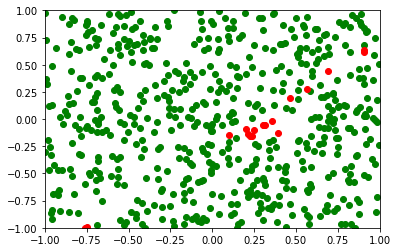

labelset:critical_slice


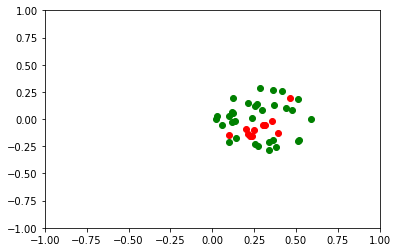

In [22]:
X = np.array(eval_payload.data_loader.dataset.X_dict['data'])
for label_name, task_name in eval_payload.labels_to_tasks.items():
    print(label_name)
    Y = np.array(Ys[label_name]).squeeze()
    preds = np.array(Ys_preds[task_name]).squeeze()

    slice_mask = Y != 0
    X_slice = X[slice_mask, :]
    pred_slice = preds[slice_mask]
    gt_slice = Y[slice_mask]
    plot_xy(X_slice, pred_slice, gt_slice)